In [1]:
import os
import pandas as pd

In [4]:
df = pd.read_csv(os.path.join('../data', 'geneset.tsv'), sep='\t', header=None, names=['gene', 'description'])

In [5]:
df.head()

,gene,description
0,GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE,The maintenance of the structure and integrity...
1,GOBP_REPRODUCTION,The production of new individuals that contain...
2,GOBP_SINGLE_STRAND_BREAK_REPAIR,The repair of single strand breaks in DNA. Rep...
3,GOBP_REGULATION_OF_DNA_RECOMBINATION,"Any process that modulates the frequency, rate..."
4,GOBP_REGULATION_OF_MITOTIC_RECOMBINATION,"Any process that modulates the frequency, rate..."


In [6]:
# combine gene and description into one column
df_text = df['gene'] + ': ' + df['description']

In [7]:
# rename df_text column to "text"
df_text = df_text.rename('text')

In [8]:
df_text.head()

0    GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE: The mai...
1    GOBP_REPRODUCTION: The production of new indiv...
2    GOBP_SINGLE_STRAND_BREAK_REPAIR: The repair of...
3    GOBP_REGULATION_OF_DNA_RECOMBINATION: Any proc...
4    GOBP_REGULATION_OF_MITOTIC_RECOMBINATION: Any ...
Name: text, dtype: object

In [9]:
df_text.shape

(7747,)

In [13]:
df["text"] = df_text

In [14]:
df.to_parquet(os.path.join('../../latent-scope/data/genesets', 'input.parquet'))

In [12]:
df.head()

,gene,description
0,GOBP_MITOCHONDRIAL_GENOME_MAINTENANCE,The maintenance of the structure and integrity...
1,GOBP_REPRODUCTION,The production of new individuals that contain...
2,GOBP_SINGLE_STRAND_BREAK_REPAIR,The repair of single strand breaks in DNA. Rep...
3,GOBP_REGULATION_OF_DNA_RECOMBINATION,"Any process that modulates the frequency, rate..."
4,GOBP_REGULATION_OF_MITOTIC_RECOMBINATION,"Any process that modulates the frequency, rate..."


In [13]:
df_text.to_csv(os.path.join('../data', 'geneset_text.csv'), index=False, header=True)

In [ ]:
# embed with node script
# node embed-csv.mjs data/geneset_text.csv "text"

In [15]:
# umap and stuff
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json

In [16]:
name = "geneset_text"

In [20]:
with open('../data/{name}-embeddings.json'.format(name=name), 'r') as f:
    metadata = json.load(f)
with open('../data/{name}-embeddings.bin'.format(name=name), 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [21]:
embeddings.shape

(7747, 1536)

In [22]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.075,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [23]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.075, n_neighbors=50, random_state=42, verbose=True)
Fri Jun 16 14:14:25 2023 Construct fuzzy simplicial set
Fri Jun 16 14:14:25 2023 Finding Nearest Neighbors
Fri Jun 16 14:14:25 2023 Building RP forest with 9 trees
Fri Jun 16 14:14:26 2023 NN descent for 13 iterations


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 16 14:14:34 2023 Finished Nearest Neighbor Search
Fri Jun 16 14:14:35 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jun 16 14:14:47 2023 Finished embedding


In [24]:
umap_embeddings.shape

(7747, 2)

In [25]:
# normalize the umap_embeddings to be between -1 and 1
umap_embeddings = (umap_embeddings - umap_embeddings.min()) / (umap_embeddings.max() - umap_embeddings.min())

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_13281/3739994091.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')


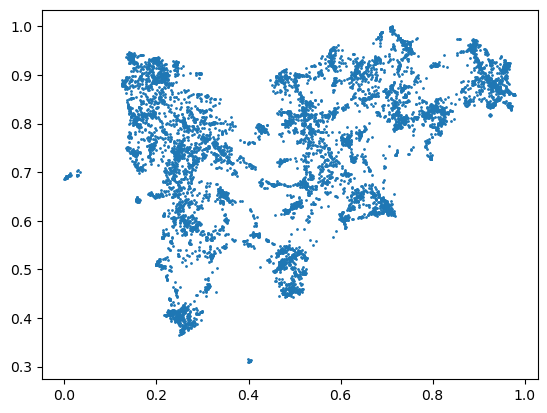

In [26]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')
plt.show()

In [27]:
def cluster(umap_embeddings, min_cluster_size=20, min_samples=10):
  # Create an HDBSCAN instance with custom parameters
  # cluster based on UMAP
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
  clusterer.fit(umap_embeddings)

  cluster_labels = clusterer.labels_
  return cluster_labels



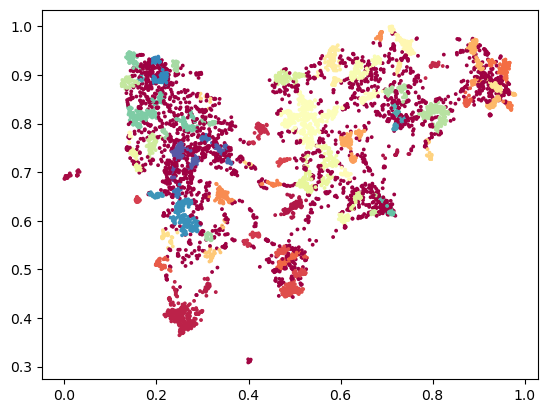

In [30]:
cluster_labels = cluster(umap_embeddings, 5, 15)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)
  

In [31]:
unique_labels.shape

(106,)

In [32]:
def assign_clusters(umap_embeddings, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    non_noise_labels = unique_labels[unique_labels != -1]
    centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
    from scipy.spatial.distance import cdist
    # Assign noise points to the closest cluster centroid
    noise_points = umap_embeddings[cluster_labels == -1]
    closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

    # Update cluster_labels with the new assignments for noise points
    noise_indices = np.where(cluster_labels == -1)[0]
    new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
    assigned_labels = cluster_labels.copy()
    assigned_labels[noise_indices] = new_assignments
    return assigned_labels

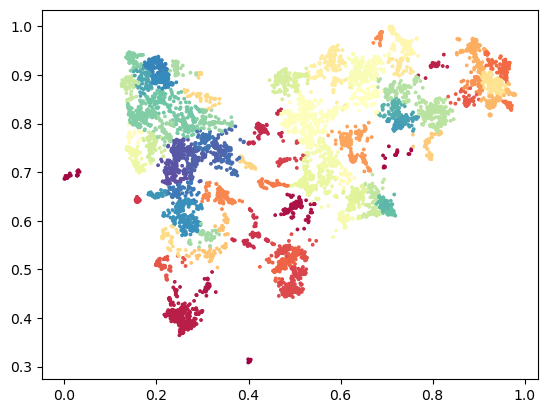

In [33]:
# plot embedding with cluster labels
assigned_labels = assign_clusters(umap_embeddings, cluster_labels)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=assigned_labels, s=3, cmap='Spectral')


In [34]:
#write embedding to csv file with header x,y
np.savetxt("../data/{name}-umap.csv".format(name=name), umap_embeddings, delimiter=",", header="x,y", comments='')

In [35]:
np.savetxt("../data/{name}-hdbscan.csv".format(name=name), assigned_labels, delimiter=",", header="cluster", comments="")


In [37]:
# 1D embeddings
# reduce dimensionality with umap
reducer1D = umap.UMAP(
    n_neighbors=50,
    min_dist=0.075,
    metric='cosine',
    random_state=42,
    n_components=1,
    verbose=True,
)

In [38]:
umap_embeddings1d = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.075, n_components=1, n_neighbors=50, random_state=42, verbose=True)
Fri Jun 16 17:03:03 2023 Construct fuzzy simplicial set
Fri Jun 16 17:03:03 2023 Finding Nearest Neighbors
Fri Jun 16 17:03:03 2023 Building RP forest with 9 trees
Fri Jun 16 17:03:03 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 16 17:03:05 2023 Finished Nearest Neighbor Search
Fri Jun 16 17:03:05 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Jun 16 17:03:16 2023 Finished embedding


In [39]:
umap_embeddings1d

array([[12.451398 ],
       [-6.7658887],
       [12.747272 ],
       ...,
       [ 6.631063 ],
       [19.535099 ],
       [19.177588 ]], dtype=float32)

In [40]:
# reorder the df according to the sorted order of umap_embeddings1d
# keep the original index
df['umap1d'] = umap_embeddings1d
df2 = df.sort_values(by=['umap1d'])


In [41]:
df2.head()

,gene,description,umap1d
372,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PE...,The process in which an antigen-presenting cel...,-12.925224
1702,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,The process in which an antigen-presenting cel...,-12.919284
375,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EN...,The process in which an antigen-presenting cel...,-12.914914
374,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EX...,The process in which an antigen-presenting cel...,-12.914328
1696,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION,The process in which an antigen-presenting cel...,-12.914102


In [42]:
df2.to_csv(os.path.join('../data', 'geneset_ordered.tsv'), sep='\t', index=True, header=True)